In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pylab
import pickle
import copy
import processing
import matplotlib.animation as animation
import datetime
import multiprocessing as mp
import processing

%matplotlib inline

共通変数をここに定義

In [2]:
DataName='sensor7_AccX'
SensorName='sensor7'
Axis='AccX'
SampleNum=16
width=3000

In [3]:
WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-07-11'

StudyDataPath=WORKSPACE_PATH+'/Study/'+DataName+'/'
if not os.path.exists(StudyDataPath): os.makedirs(StudyDataPath)

GlaphDataPath=WORKSPACE_PATH+'/Graph/'+DataName+'/power&kullback/'
if not os.path.exists(GlaphDataPath): os.makedirs(GlaphDataPath)

StudyDataModelPicPath=WORKSPACE_PATH+'/Study/'+DataName+'/modelPic/'
if not os.path.exists(StudyDataModelPicPath): os.makedirs(StudyDataModelPicPath)

WindowDataPath=WORKSPACE_PATH+'/window/'
RawDataPath=WORKSPACE_PATH+'/raw/'

In [4]:
"""
    encordData,decordData
    firstNum:
    goalNum:
    commonLabel:共通名前
"""
def MakeGlaph(encordData,decordData,firstNum,goalNum,commonLabel):
    eRow, eCol=encordData.shape
    dRow, dCol=decordData.shape
    
    if eRow!=dRow | eCol!=dCol:
        return -1
    start = firstNum
    goal=goalNum
    print str(start)+' is start '+str(goal)+' is goal'
    dataE = encordData.reshape(eRow*eCol,1)[start:goal]
    dataD = decordData.reshape(dRow*dCol,1)[start:goal]
    plt.clf() 
    plt.figure(figsize=(100,50))
    plt.plot(range(0,len(dataE)),dataE,'--r',label="raw data")
    plt.plot(range(0,len(dataD)),dataD,'b',label="reconstruct")
    plt.legend(loc='best')
    plt.title(str(start)+"-"+str(goal))
    plt.savefig(commonLabel+'-'+str(start)+"-"+str(goal)+'-'+'glaph')
    plt.clf()
    plt.cla()
    plt.close('all')
    return 1

すべてのデータを読みdし、グラフ化する

並列処理でグラフを作成する

Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000
Graph range=0 : 3000
Graph range=3000 : 6000
Graph range=6000 : 9000
Graph range=9000 : 12000
Graph range=12000 : 15000


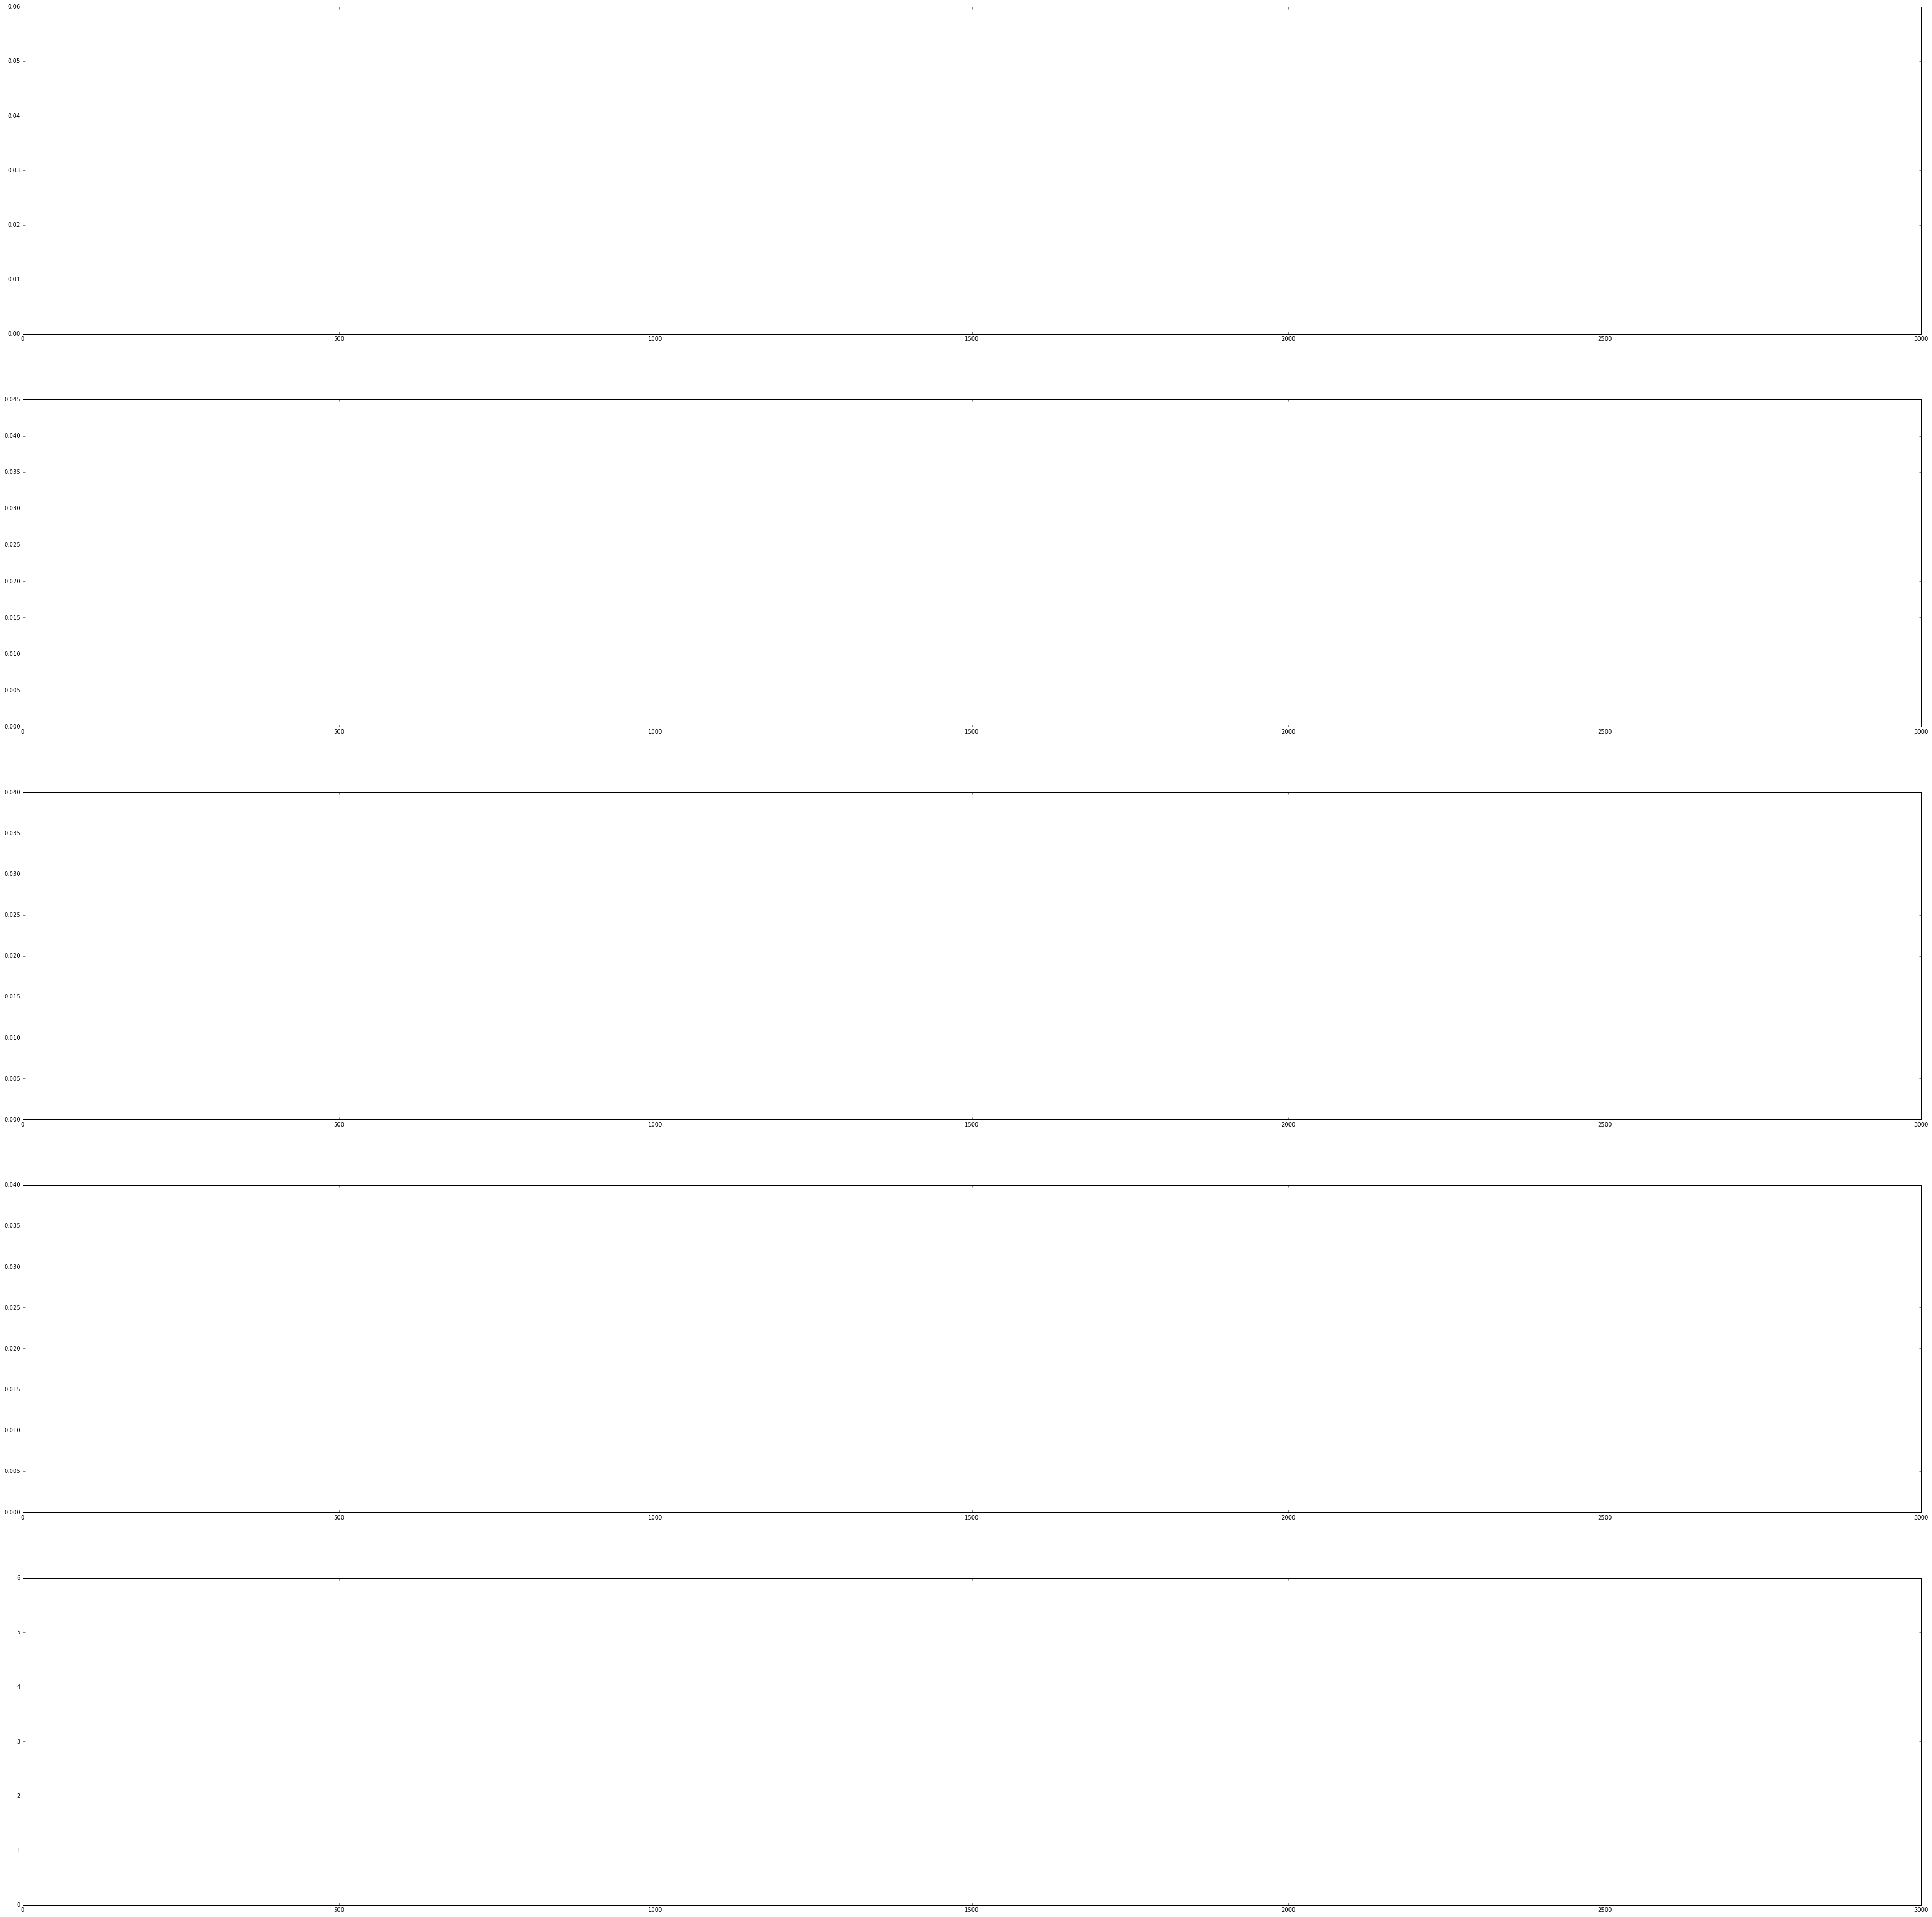

In [5]:
# define SaveFileName
# 8, 4, 12, 16, 32, 64
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats

def kld(p, q):
    """Calculates Kullback–Leibler divergence"""
    p = np.array(p)
    q = np.array(q)
    return np.sum(p * np.log(p / q), axis=(p.ndim - 1))
 
def jsd(p, q):
    """Calculates Jensen-Shannon Divergence"""
    p = np.array(p)
    q = np.array(q)
    m = 0.5 * (p + q)
    return 0.5 * kld(p, m) + 0.5 * kld(q, m)

AllEncoding_dim = [4, 8, 12, 16, 32, 64]  
window = processing.LoadDicDataFromFileNPZ(WindowDataPath+SensorName+'_'+Axis+'_train_edim=8.npz')
width = 3000
fig = plt.figure(figsize=(60,60))
ax = fig.add_subplot(511)
bx = fig.add_subplot(512)
cx = fig.add_subplot(513)
dx = fig.add_subplot(514)
ex = fig.add_subplot(515)



for encoding_dim in AllEncoding_dim:
    SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
    SaveFileNameGraph=GlaphDataPath+ DataName+'_edim='+str(encoding_dim)

    reconstructData = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameDecord)

    # FFT 
    fftDataE = np.array([])
    fftDataD = np.array([])
    for i in range(len(window)):
            fftDataE=np.append(fftDataE, fftpack.fft( window[i])[1:(SampleNum/2)+1])
            fftDataD=np.append(fftDataD, fftpack.fft( reconstructData[i])[1:(SampleNum/2)+1])
    fftDataE = fftDataE.reshape(len(fftDataE)/(SampleNum/2),(SampleNum/2))
    fftDataD = fftDataD.reshape(len(fftDataD)/(SampleNum/2),(SampleNum/2))
    processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-fft-raw',fftDataE)
    processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-fft-restruct',fftDataD)
    
    
    # Power
    PowerDataE = np.imag(fftDataE)**2+np.real(fftDataE)**2
    PowerDataD = np.imag(fftDataD)**2+np.real(fftDataD)**2
    processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-power-raw',PowerDataE)
    processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+'_edim='+str(encoding_dim)+'-power-restruct',PowerDataD)
    
    # to distribution
    DistributePowerDataE = np.array([])
    DistributePowerDataD = np.array([])

    for i in range( PowerDataE.shape[0] ):
        DistributePowerDataE = np.append(DistributePowerDataE,PowerDataE[i]/( np.sum(PowerDataE[i]) ))
    DistributePowerDataE = DistributePowerDataE.reshape(PowerDataE.shape)
    
    for i in range( PowerDataD.shape[0] ):
        DistributePowerDataD = np.append(DistributePowerDataD,PowerDataD[i]/( np.sum(PowerDataD[i]) ))
    DistributePowerDataD = DistributePowerDataD.reshape(PowerDataD.shape)
    
    # Kullback-leibler-divergence plot
    ArrayKLD = np.array([])
    for i in range(DistributePowerDataE.shape[0]):
        ArrayKLD = np.append(ArrayKLD, kld(DistributePowerDataE[i],DistributePowerDataD[i]))

    # FFT plot
    for i in range(width,PowerDataE.shape[0],width):
        start =i-width 
        goal=i

        dataE = PowerDataE[start:goal,:4]
        dataD = PowerDataD[start:goal,:4]
        data = ArrayKLD[start:goal]
        #dataE,dataDをPower
        ax.plot(range(0,len(dataE)),dataE[:,0],'r',label="train data No0")
        bx.plot(range(0,len(dataE)),dataE[:,1],'r',label="train data No1")
        cx.plot(range(0,len(dataE)),dataE[:,2],'r',label="train data No2")
        dx.plot(range(0,len(dataE)),dataE[:,3],'r',label="train data No3")

        ax.plot(range(0,len(dataD)),dataD[:,0],'b',label="reconstruct No0")
        bx.plot(range(0,len(dataD)),dataD[:,1],'b',label="reconstruct No1")
        cx.plot(range(0,len(dataD)),dataD[:,2],'b',label="reconstruct No2")
        dx.plot(range(0,len(dataD)),dataD[:,3],'b',label="reconstruct No3")

        ex.plot(range(0,len(data)),data,'g',label="Kullback")

        ax.legend(loc='best')
        ax.set_title(str(start)+"-"+str(goal))
        
        bx.legend(loc='best')
        bx.set_title(str(start)+"-"+str(goal))
        
        cx.legend(loc='best')
        cx.set_title(str(start)+"-"+str(goal))
        
        dx.legend(loc='best')
        dx.set_title(str(start)+"-"+str(goal))
        
        ex.legend(loc='best')
        ex.set_title(str(start)+"-"+str(goal))
 
        ax.figure.savefig(SaveFileNameGraph+'-'+str(start)+"-"+str(goal)+'-'+'No0-3-kld&power'+'-glaph')
        
        ax.clear()
        bx.clear()
        cx.clear()
        dx.clear()
        ex.clear()
        print 'Graph range='+str(start)+' : '+str(goal)
        time.sleep(3)
    
    for i in range(width,PowerDataE.shape[0],width):
        start =i-width 
        goal=i

        dataE = PowerDataE[start:goal,4:]
        dataD = PowerDataD[start:goal,4:]
        data = ArrayKLD[start:goal]
        #dataE,dataDをPower
        ax.plot(range(0,len(dataE)),dataE[:,0],'r',label="train data No4")
        bx.plot(range(0,len(dataE)),dataE[:,1],'r',label="train data No5")
        cx.plot(range(0,len(dataE)),dataE[:,2],'r',label="train data No6")
        dx.plot(range(0,len(dataE)),dataE[:,3],'r',label="train data No7")

        ax.plot(range(0,len(dataD)),dataD[:,0],'b',label="reconstruct No4")
        bx.plot(range(0,len(dataD)),dataD[:,1],'b',label="reconstruct No5")
        cx.plot(range(0,len(dataD)),dataD[:,2],'b',label="reconstruct No6")
        dx.plot(range(0,len(dataD)),dataD[:,3],'b',label="reconstruct No7")

        ex.plot(range(0,len(data)),data,'g',label="Kullback")

        ax.legend(loc='best')
        ax.set_title(str(start)+"-"+str(goal))
        
        bx.legend(loc='best')
        bx.set_title(str(start)+"-"+str(goal))
        
        cx.legend(loc='best')
        cx.set_title(str(start)+"-"+str(goal))
        
        dx.legend(loc='best')
        dx.set_title(str(start)+"-"+str(goal))
        
        ex.legend(loc='best')
        ex.set_title(str(start)+"-"+str(goal))
 
        ax.figure.savefig(SaveFileNameGraph+'-'+str(start)+"-"+str(goal)+'-'+'No4-7-kld&power'+'-glaph')
        
        ax.clear()
        bx.clear()
        cx.clear()
        dx.clear()
        ex.clear()


In [6]:
window.size

254736